# Performance Notebook

In [1]:
import itertools
import string
import sys
import time

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import spacetimepy


def name_generator(size):
    """Generate all name of given size using alphabetic lowercase letters."""
    alphabet = string.ascii_lowercase
    for name_tuple in itertools.product(alphabet, repeat=size):
        yield "".join(name_tuple)

pymonitor = spacetimepy.init_monitoring(db_path="performance.db", performance=True)

def get_and_clear_performance():
    data = pymonitor.performance_data.copy()
    pymonitor.performance_data = {
                "function_starts": [],
                "function_returns": [],
                "line_events": [],
                "line_failed_serialization": 0,
                "line_failed_type": set(),
                "line_captured_locals": 0,
                "function_failed_serialization": 0,
                "function_failed_type": set(),
                "function_captured_locals": 0,
            }
    return data

## Performance depending size of args

In [2]:
def custom_args_nm(arg):
    pass

@spacetimepy.pymonitor(mode="function")
def custom_args_m(arg):
    pass

size = []
times1 = []
times2 = []

for arg_n in tqdm.trange(1, 10000):
    arg = {name: i for i, name in itertools.islice(enumerate(name_generator(8)), arg_n)}

    t1 = time.perf_counter_ns()
    custom_args_m(arg)
    t2 = time.perf_counter_ns()

    size.append(sys.getsizeof(arg))
    times1.append((t2 - t1) / 1_000_000_000)
    del arg

for arg_n in tqdm.trange(1, 10000):
    arg = {name: i for i, name in itertools.islice(enumerate(name_generator(8)), arg_n)}

    t3 = time.perf_counter_ns()
    custom_args_nm(arg)
    t4 = time.perf_counter_ns()

    times2.append((t4 - t3) / 1_000_000_000)
    del arg

100%|██████████| 9999/9999 [00:08<00:00, 1216.90it/s] 


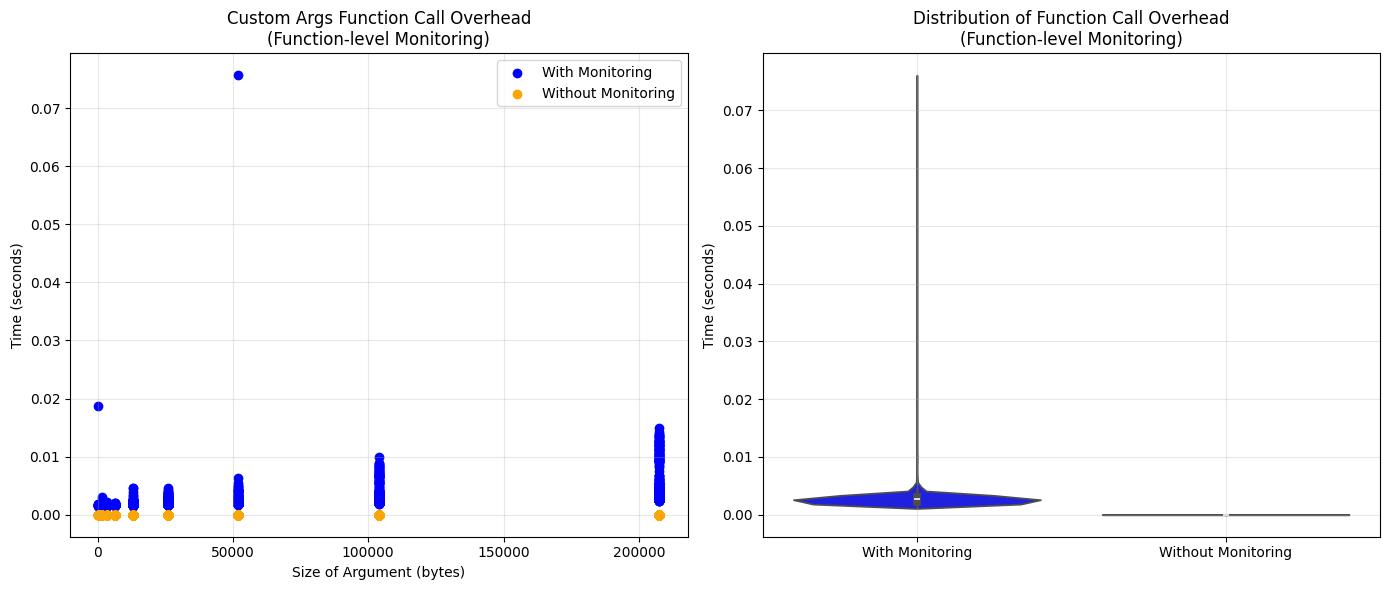

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
axes[0].scatter(size, times1, color='blue', label='With Monitoring')
axes[0].scatter(size, times2, color='orange', label='Without Monitoring')
axes[0].set_title('Custom Args Function Call Overhead\n(Function-level Monitoring)')
axes[0].set_xlabel('Size of Argument (bytes)')
axes[0].set_ylabel('Time (seconds)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Violin plot
sns.violinplot(data=[times1, times2], palette=["blue", "orange"], ax=axes[1])
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['With Monitoring', 'Without Monitoring'])
axes[1].set_title('Distribution of Function Call Overhead\n(Function-level Monitoring)')
axes[1].set_ylabel('Time (seconds)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [3]:
perf_data = get_and_clear_performance()

## Performance by Line

In [4]:
from collections import defaultdict


def simple_function(n):
    tmp = []
    for i in range(n):
        tmp.append(i + tmp[-1] if len(tmp) > 0 else 0)
    return sum(tmp)

@spacetimepy.pymonitor(mode="line")
def simple_function_line(n):
    tmp = []
    for i in range(n):
        tmp.append(i + tmp[-1] if len(tmp) > 0 else 0)
    return sum(tmp)

@spacetimepy.pymonitor(mode="line", use_tag_line=True)
def simple_function_tag_line(n):
    tmp = []
    for i in range(n): #tag
        tmp.append(i + tmp[-1] if len(tmp) > 0 else 0)
    return sum(tmp)

@spacetimepy.pymonitor(mode="function")
def simple_function_function(n):
    tmp = []
    for i in range(n):
        tmp.append(i + tmp[-1] if len(tmp) > 0 else 0)
    return sum(tmp)


times = defaultdict(list)

N = 100

for i in tqdm.trange(N):
    t1 = time.perf_counter_ns()
    simple_function_line(i)
    t2 = time.perf_counter_ns()
    times["line"].append(t2 - t1)


for i in tqdm.trange(N):
    t1 = time.perf_counter_ns()
    simple_function_function(i)
    t2 = time.perf_counter_ns()
    times["function"].append(t2 - t1)


for i in tqdm.trange(N):
    t1 = time.perf_counter_ns()
    simple_function_tag_line(i)
    t2 = time.perf_counter_ns()
    times["tag_line"].append(t2 - t1)

for i in tqdm.trange(N):
    t1 = time.perf_counter_ns()
    simple_function(i)
    t2 = time.perf_counter_ns()
    times["no_monitoring"].append(t2 - t1)

100%|██████████| 100/100 [00:00<00:00, 314415.59it/s]


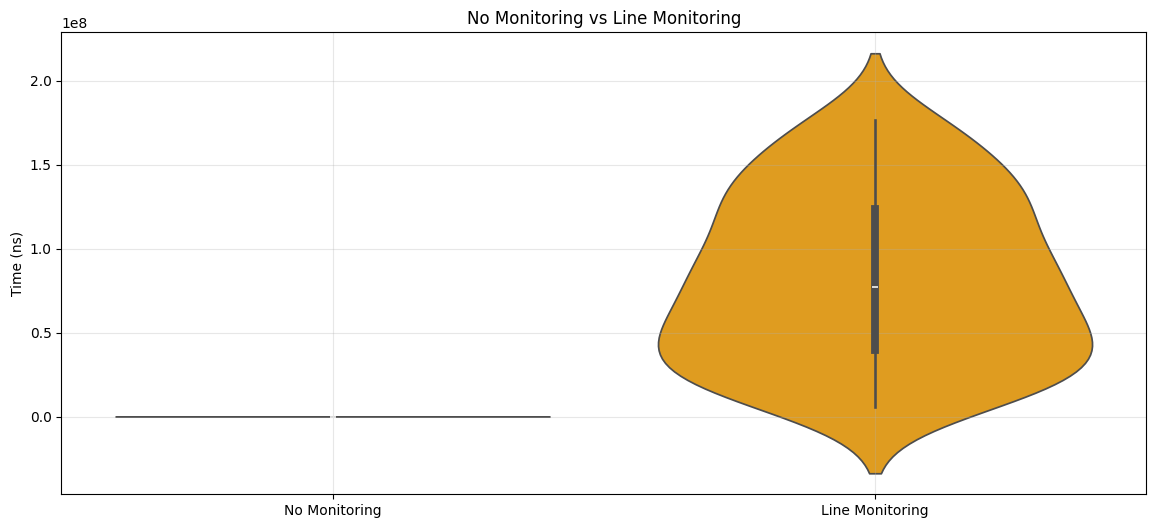

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.3)


